In [2]:
%load_ext autoreload
%notebook autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings

from IndexUtils import * 
from TileUtils import *
from featurematching import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist

from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


In [4]:
corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

corner_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\\"

output_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\registration\\"

descriptor_kwds = {
    "angle_step"        : 5,
    "azimuth_radius"    : 500
}

corners, _ = calcDescriptors(corners, **descriptor_kwds)

  0%|          | 0/127256 [00:00<?, ?it/s]

In [5]:
with open("SmartDictV2.p", 'rb') as f:
    tile_coords = pickle.load(f)

In [18]:
# r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0930J.tif"
# tile_name = f"48201C0660L"
tile_name = f"48201C0930J"

with open(f"{corner_dir}{tile_name}.pickle", 'rb') as f:
    x = pickle.load(f)    
    corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.001]
    corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
    print(f"{len(corner_bbox)} / {len(x)}")

im_file    = r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\\" + tile_name + ".tif"
him_file   = r"D:\RECTDNN\processing\2024-10-11_15-08-46\half_size\\" + tile_name + ".tif"

curr_tn = os.path.basename(im_file.split(".")[0])[:-1]
curr_tf = os.path.basename(im_file.split(".")[0])[-1]

ra = rio.open(im_file)
bounds  = ra.bounds
image   = ra.read(1)

bounds, RLNN = findBounds(im_file, None)
bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()

current_tile_coords = tile_coords.get(curr_tn, None)
if current_tile_coords is None:
    raise(Exception(f"Could not find tile in detections {curr_tn}"))

current_tf_coords = current_tile_coords.get(curr_tf, None)
if current_tf_coords is None:
    # warnings.warn(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default")
    print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]}")
    curr_tf = list(current_tile_coords.keys())[0]
    

real_x, real_y = bbox_to_coords_realworld(tile_coords[curr_tn][curr_tf]["coords"][0])
pic_x, pic_y   = bbox_to_coords_raster(bbox)

affine = affineTransformation(pic_x, pic_y, real_x, real_y)

# corner_arry = streetcorners[os.path.basename(tile).split(".")[0] + ".pickle"] * 2# streetresults_struct[tile_coords[out_name]['input_file']]
corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
corner_arry = cleanCenterBBOX(corner_arry, bbox)

# USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
im_corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])

bounds_poly = enlarged_bounds(ra, n=2)

corners_curr = gpd.clip(corners, bounds_poly)

210 / 210
Could not find tile extension in detections 48201C0930 - J, using default 0


In [32]:
tile_coords[curr_tn][curr_tf]

{'coords': [array([-1.0593e+07,   3.471e+06, -1.0586e+07,  3.4631e+06]),
  array([-1.0592e+07,  3.4713e+06, -1.0585e+07,  3.4635e+06])],
 'indexes': ['48201CIND0.tif', '48201CIND0_1196.tif'],
 'pix': [array([     7776.4,      6962.6,      8310.7,      7570.4]),
  array([     7790.6,        6916,      8325.2,      7526.5])],
 'dates': [datetime.datetime(2000, 4, 20, 0, 0),
  datetime.datetime(1996, 11, 23, 0, 0)]}

In [29]:

def registerImagesV1(ra,im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, r_initial=500, verbose=1, ):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    

    for i in range(20):
        
        r_current = r_initial * 0.9 ** i

        if i == 0:
            matching_results, im_corner_gdf, corners_curr = matching(im_corner_gdf, corners_curr, ratio_threshold=0.95, **descriptor_kwds)
            matrix, distances = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, im_corner_gdf=im_corner_gdf, plot=verbose>3)
        else:
            matching_results, _, _ = matching_distances(im_corner_gdf_adj, corners_curr, match_radius=r_current, **descriptor_kwds)
            matrix, distances = iterativeAdjustFromMatching(matching_results, plot=verbose>3)

        compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 

        rev_adj = compoundedAdjustment @ flip
        current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        if verbose > 2:
            plt.figure()
            plt.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1])
            test = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            plt.scatter(test[:, 0], test[:, 1])
            plt.show()

        im_corner_gdf_adj = im_corner_gdf.copy()
        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])
        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

    return current_adjustment

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

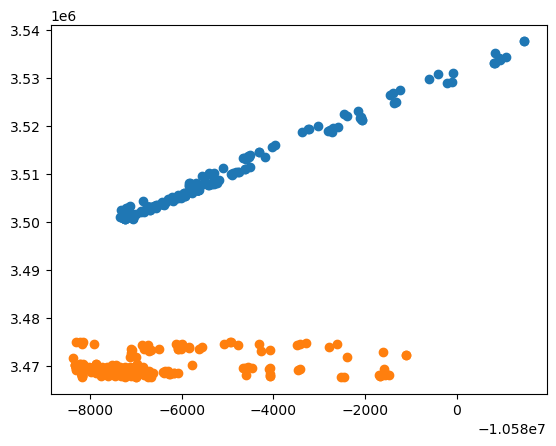

[ 2.2152e-10  3.2534e-10       7.459      14.918      14.918] 90


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/4263 [00:00<?, ?it/s]

IndexError: list index out of range

In [31]:

prev_transform = getMatrixFromAffine(ra.transform)

current_adjustment = registerImagesV1(ra,im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, verbose=3)

print(current_adjustment - prev_transform)

with rio.open(f"{output_dir}{tile_name}.tif", 'w',
                driver='GTiff', count=1, dtype=np.uint8,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                    dst.write(image, 1) 